
=== SJF (Preemptive) ===


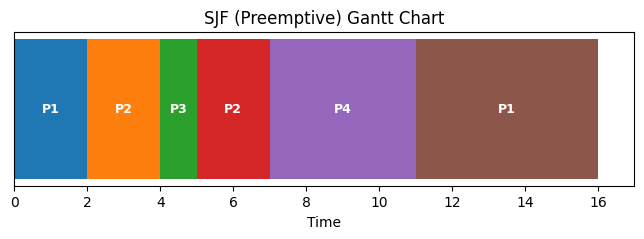

,PID,AT,BT,Priority,ST,CT,TAT,WT
0,P1,0,7,2,0,16,16,9
1,P2,2,4,1,2,7,5,1
2,P3,4,1,3,4,5,1,0
3,P4,5,4,2,7,11,6,2


Average Turnaround Time = 7.00
Average Waiting Time   = 3.00

=== Priority Scheduling ===


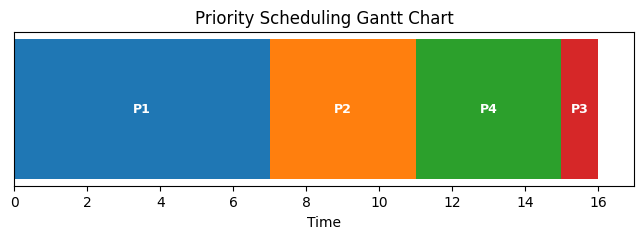

,PID,AT,BT,Priority,ST,CT,TAT,WT
0,P1,0,7,2,0,7,7,0
1,P2,2,4,1,7,11,9,5
2,P3,4,1,3,15,16,12,11
3,P4,5,4,2,11,15,10,6


Average Turnaround Time = 9.50
Average Waiting Time   = 5.50


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Process:
    pid: str
    arrival: int
    burst: int
    priority: int = 0
    remaining: int = None
    start: int = None
    completion: int = None
    tat: int = None
    wt: int = None

    def __post_init__(self):
        self.remaining = self.burst

# ---------- Metrics + Table ----------

def calculate_metrics(processes: List[Process], timeline: List[Tuple[str, int, int]]):
    for p in processes:
        for pid, s, e in timeline:
            if pid == p.pid and p.start is None:
                p.start = s
            if pid == p.pid:
                p.completion = e
        p.tat = p.completion - p.arrival
        p.wt = p.tat - p.burst

    df = pd.DataFrame([{
        "PID": p.pid,
        "AT": p.arrival,
        "BT": p.burst,
        "Priority": p.priority,
        "ST": p.start,
        "CT": p.completion,
        "TAT": p.tat,
        "WT": p.wt
    } for p in processes])

    avg_tat = df["TAT"].mean()
    avg_wt = df["WT"].mean()

    display(df)
    print(f"Average Turnaround Time = {avg_tat:.2f}")
    print(f"Average Waiting Time   = {avg_wt:.2f}")

# ---------- Gantt Chart ----------

def draw_gantt_chart(timeline: List[Tuple[str, int, int]], title: str):
    fig, ax = plt.subplots(figsize=(8,2))
    for (pid, start, end) in timeline:
        ax.barh(0, end-start, left=start, height=0.3, align='center')
        ax.text((start+end)/2, 0, pid, ha='center', va='center', color='white', fontsize=9, fontweight='bold')
    ax.set_yticks([])
    ax.set_xlim(0, max(end for _,_,end in timeline)+1)
    ax.set_xlabel("Time")
    ax.set_title(title)
    plt.show()

# ---------- SJF Preemptive ----------

def sjf_preemptive(processes: List[Process]):
    n = len(processes)
    procs = sorted(processes, key=lambda p: (p.arrival, p.pid))
    t = 0
    done = 0
    timeline = []
    running_pid = None

    while done < n:
        ready = [p for p in procs if p.arrival <= t and p.remaining > 0]
        if not ready:
            t += 1
            continue
        ready.sort(key=lambda p: (p.remaining, p.arrival, p.pid))
        p = ready[0]
        if running_pid != p.pid:
            start = t
            timeline.append((p.pid, start, start+1))
            running_pid = p.pid
        else:
            last_pid, start, end = timeline.pop()
            timeline.append((last_pid, start, end+1))
        p.remaining -= 1
        t += 1
        if p.remaining == 0:
            done += 1

    print("\n=== SJF (Preemptive) ===")
    draw_gantt_chart(timeline, "SJF (Preemptive) Gantt Chart")
    calculate_metrics(procs, timeline)

# ---------- Priority Scheduling (Non-preemptive) ----------

def priority_scheduling(processes: List[Process]):
    n = len(processes)
    procs = sorted(processes, key=lambda p: (p.arrival, p.priority, p.pid))
    t = 0
    done = set()
    timeline = []

    while len(done) < n:
        ready = [p for p in procs if p.arrival <= t and p.pid not in done]
        if not ready:
            t += 1
            continue
        ready.sort(key=lambda p: (p.priority, p.arrival, p.pid))  # lower value = higher priority
        p = ready[0]
        start = t
        end = start + p.burst
        timeline.append((p.pid, start, end))
        p.remaining = 0
        t = end
        done.add(p.pid)

    print("\n=== Priority Scheduling ===")
    draw_gantt_chart(timeline, "Priority Scheduling Gantt Chart")
    calculate_metrics(procs, timeline)

# ---------- Example Run ----------

processes = [
    Process("P1", 0, 7, 2),
    Process("P2", 2, 4, 1),
    Process("P3", 4, 1, 3),
    Process("P4", 5, 4, 2),
]

sjf_preemptive([Process(p.pid, p.arrival, p.burst, p.priority) for p in processes])
priority_scheduling([Process(p.pid, p.arrival, p.burst, p.priority) for p in processes])
